In [1]:
import os, pdb
import numpy as np
import fitsio
from astropy.table import Table, hstack
import matplotlib.pyplot as plt

In [2]:
from desiutil.plots import plot_sky_binned, init_sky
from desimodel.footprint import radec2pix

In [3]:
%matplotlib inline

In [20]:
camera, ver = 'decam', '-v5-3'
allimlist = Table(fitsio.read('dr8-ondisk-{}{}.fits'.format(camera, ver)))
imlist = allimlist[allimlist['qkeep']]
print('Keeping {}/{} {}{} images.'.format(len(imlist), len(allimlist), camera, ver))

Keeping 137306/145141 decam-v5-3 images.


In [22]:
allzpts = Table(fitsio.read('survey-ccds-decam-dr8.fits.gz'))
_, uindx = np.unique(allzpts['image_filename'], return_index=True)
zpts = allzpts[uindx]
print('Keeping {}/{} {} zeropoints.'.format(len(zpts), len(allzpts), camera))

Keeping 121314/7311253 decam zeropoints.


In [40]:
imlist[:3]

filename,object,propid,expnum,obstype,wcscal,photcal,yshift,proctype,prodtype,exptime,ra,dec,date_obs,mjd_obs,airmass,filter,plver,procdate,plprocid,qkeep,flag1,flag2
bytes200,bytes40,bytes20,int64,bytes10,bytes20,bytes20,float32,bytes20,bytes20,float32,float64,float64,bytes26,float64,float32,bytes32,bytes8,bytes19,bytes20,bool,int64,bool
CPDES82/c4d_130911_062753_ooi_g_v1.fits.fz,DES survey hex -28-4 tiling 2,2012B-0001,232822,object,Successful,empty,nan,InstCal,image,90.0,356.4611249999999,0.07508333333333334,2013-09-11T06:27:53.973535,56546.26937469,1.23,g DECam SDSS c0001 4720.0 1520.0,V3.6,2015-02-13T14:17:16,87c7a6f,True,0,False
CPDES82/c4d_130911_063202_ooi_g_v1.fits.fz,DES survey hex 4+16 tiling 2,2012B-0001,232824,object,Successful,empty,nan,InstCal,image,90.0,359.6517916666666,2.104722222222222,2013-09-11T06:32:02.091466,56546.27224643,1.24,g DECam SDSS c0001 4720.0 1520.0,V3.6,2015-02-13T14:17:20,87c7a6f,True,0,False
CPDES82/c4d_130928_015737_ooi_g_v1.fits.fz,DES survey hex -12+6 tiling 1,2012B-0001,238924,object,Successful,empty,nan,InstCal,image,90.0,358.8265416666667,0.6180555555555556,2013-09-28T01:57:37.236824,56563.08168098,1.4,g DECam SDSS c0001 4720.0 1520.0,V3.6,2015-02-13T14:20:36,87c7a6f,True,0,False


In [41]:
zpts[:3]

image_filename,image_hdu,camera,expnum,plver,procdate,plprocid,ccdname,object,propid,filter,exptime,mjd_obs,airmass,fwhm,width,height,ra_bore,dec_bore,crpix1,crpix2,crval1,crval2,cd1_1,cd1_2,cd2_1,cd2_2,yshift,ra,dec,skyrms,sig1,ccdzpt,zpt,ccdraoff,ccddecoff,ccdskycounts,ccdskysb,ccdrarms,ccddecrms,ccdphrms,ccdnastrom,ccdnphotom,ccd_cuts
bytes120,int16,bytes9,int64,bytes8,bytes19,bytes7,bytes5,bytes35,bytes10,bytes1,float32,float64,float32,float32,int16,int16,float64,float64,float32,float32,float64,float64,float32,float32,float32,float32,bool,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int32
decam/DECam_CP/CP20140810_g_v2/c4d_140815_235218_ooi_g_v2.fits.fz,1,decam,348224,V3.3.0,2014-09-05T08:06:56,8672821,S29,HexapodUpdate,2014B-0404,g,30.0,56884.99373389,1.35,4.253049,2046,4094,240.16241666666667,10.891027777777778,13422.2,6306.333,240.1624280585,10.89102382562,-1.8234518e-07,7.285107e-05,-7.2859635e-05,-1.8833764e-07,False,239.84754226428262,11.795715000739543,0.11988933,0.010756563,25.101385,25.098503,-0.070845425,-0.08212396,1.2380908,23.469625,0.07908133,0.10123539,0.022398625,353,373,0
decam/DECam_CP/CP20140810_g_v2/c4d_140815_235550_ooi_g_v2.fits.fz,1,decam,348225,V3.3.0,2014-09-05T08:06:51,8672821,S29,DECaLS_15891_g,2014B-0404,g,79.0,56884.99558084,1.35,4.416574,2046,4094,240.15745833333335,10.88425,13422.2,6306.333,240.1574501877,10.88424111551,-1.82367e-07,7.285161e-05,-7.286044e-05,-1.8725844e-07,False,239.8425632491656,11.788935631604792,0.06825077,0.006185885,25.100357,25.09846,-0.090344526,-0.12109605,1.2376176,23.47004,0.091307156,0.12762612,0.02349728,350,375,0
decam/DECam_CP/CP20140810_g_v2/c4d_140815_235730_ooi_g_v2.fits.fz,1,decam,348226,V3.3.0,2014-09-05T08:06:45,8672821,S29,DECaLS_15884_g,2014B-0404,g,74.0,56884.99682659,1.32,4.323545,2046,4094,240.63974999999996,9.329722222222223,13422.2,6306.333,240.6397644751,9.329735747765,-1.8300955e-07,7.2851886e-05,-7.285927e-05,-1.883075e-07,False,240.3265596314937,10.234417502171025,0.071075335,0.006342868,25.112234,25.10609,-0.05237481,-0.113597386,1.2369775,23.470602,0.054220174,0.12889181,0.025700446,331,357,0


In [75]:
zpts_files = []
for ff in zpts['image_filename']:
    _ff = ff.strip().split('/')
    #zpts_files.append('/'.join((_ff[1], _ff[3])).upper())
    zpts_files.append(_ff[3])
zpts_files = np.hstack(zpts_files)
imlist_files = np.hstack([ff.strip().split('/')[1] for ff in imlist['filename']])
#imlist_files = np.array([ff.strip().upper() for ff in imlist['filename']])

In [76]:
zpts_files[:3], imlist_files[:3]

(array(['c4d_140815_235218_ooi_g_v2.fits.fz',
        'c4d_140815_235550_ooi_g_v2.fits.fz',
        'c4d_140815_235730_ooi_g_v2.fits.fz'], dtype='<U34'),
 array(['c4d_130911_062753_ooi_g_v1.fits.fz',
        'c4d_130911_063202_ooi_g_v1.fits.fz',
        'c4d_130928_015737_ooi_g_v1.fits.fz'], dtype='<U34'))

In [81]:
print(np.sum(np.isin(zpts_files, imlist_files)))
print(np.sum(np.isin(imlist_files, zpts_files)))
np.intersect1d(['c4d_130911_062753_ooi_g_v1.fits.fz'], imlist_files)

0
0


array(['c4d_130911_062753_ooi_g_v1.fits.fz'], dtype='<U34')

## Read the sky and zeropoints catalogs

In [4]:
allcam = ('decam-g', 'decam-r', 'decam-z', '90prime-g', '90prime-r')

In [5]:
zpts = dict()
for band in allcam:
     zpts[band] = Table(fitsio.read('survey-ccds-{}.fits.gz'.format(band), ext=1))

In [15]:
sky = Table(fitsio.read('sky-hdrs.fits'))
sky.rename_column('camera', 'sky_camera')
sky.rename_column('ccdname', 'sky_ccdname')
sky.rename_column('expnum', 'sky_expnum')
sky.rename_column('sig1', 'sky_sig1')
print(len(sky))
#sky[:3]

4188289


## Sky-subtraction

In [44]:
def match_sky_zpts(sky, zpts, filt='decam-z', write=False):
    """Match the sky statistics to a given zeropoint catalog (of a given bandpass)."""
    skyfile = np.array([os.path.basename(ff).replace('.fits', '').strip() for ff in sky['filename']])
    zptfile = np.array(['{}-{:08d}-{}'.format(cam.strip(), exp, ccd.strip())
                        for cam, exp, ccd in zip(zpts[filt]['camera'], zpts[filt]['expnum'], zpts[filt]['ccdname'])])
    
    _, wzpt, wsky = np.intersect1d(zptfile, skyfile, return_indices=True)
    out = hstack((sky[wsky], zpts[filt][wzpt]))
    if write:
        outfile = 'sky-hdrs-{}.fits'.format(filt)
        print('Writing {}'.format(outfile))
        out.write(outfile, overwrite=True)
    return out    

In [46]:
if False:
    for cam in ('decam-g', 'decam-r', 'decam-z'):
        match_sky_zpts(sky, zpts, filt=cam, write=True)

In [17]:
out = match_sky_zpts(sky, zpts, filt='decam-z')
out[:3]

filename,sky_camera,sky_ccdname,sky_expnum,legpipev,plver,imgdsum,procdate,sky_sig1,s_mode,s_med,s_cmed,s_john,s_p0,s_p10,s_p20,s_p30,s_p40,s_p50,s_p60,s_p70,s_p80,s_p90,s_p100,s_fmaskd,s_fine,image_filename,image_hdu,camera,expnum,ccdname,object,propid,filter,exptime,mjd_obs,airmass,fwhm,width,height,ra_bore,dec_bore,crpix1,crpix2,crval1,crval2,cd1_1,cd1_2,cd2_1,cd2_2,yshift,ra,dec,skyrms,sig1,ccdzpt,zpt,ccdraoff,ccddecoff,ccdskycounts,ccdskymag,ccdrarms,ccddecrms,ccdphrms,ccdnmatch,ccd_cuts
bytes54,bytes5,bytes3,int32,bytes21,bytes8,int64,bytes19,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes120,int16,bytes9,int64,bytes5,bytes35,bytes10,bytes1,float32,float64,float32,float32,int16,int16,float64,float64,float32,float32,float64,float64,float32,float32,float32,float32,bool,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int32
decam/splinesky/00292/00292594/decam-00292594-N1.fits,decam,N1,292594,dr8-sky-23-gb530baa,V3.1.1,4235729473,2014-06-18T16:51:20,13.983541,776.33,776.57654,776.36566,775.9702,-140.39929,-18.0141,-11.847168,-7.38501,-3.5635986,0.0026245117,3.5716553,7.397522,11.879761,18.107666,72.725464,0.12891395,0.09888925,decam/NonDECaLS/CP20140316/c4d_140317_083408_ooi_z_v1.fits.fz,31,decam,292594,N1,hexapod update,2013B-0612,z,30.0,56733.35605804,1.26,7.0714293,2046,4094,242.30483333333333,6.20575,-104.2001,14825.0,242.3048143948,6.205741087661,-1.9446065e-07,7.285809e-05,-7.286214e-05,-1.9358878e-07,False,241.36760338907385,6.125098072247918,0.47049177,13.982382,24.926756,24.927584,-0.07492185,-0.20437104,25.88311,20.042965,0.084980994,0.20796564,0.019522201,279,0
decam/splinesky/00292/00292594/decam-00292594-N10.fits,decam,N10,292594,dr8-sky,V3.1.1,1818148087,2014-06-18T16:51:20,13.965536,775.6102,775.929,775.66907,775.2322,-75.68335,-17.904541,-11.779724,-7.343872,-3.5419922,0.0037231445,3.5612183,7.3675356,11.8341675,18.039062,73.91138,0.14357395,0.10999491,decam/NonDECaLS/CP20140316/c4d_140317_083408_ooi_z_v1.fits.fz,40,decam,292594,N10,hexapod update,2013B-0612,z,30.0,56733.35605804,1.26,7.280891,2046,4094,242.30483333333333,6.20575,-2358.6,4176.667,242.3048143948,6.205741087661,-1.9446065e-07,7.285809e-05,-7.286214e-05,-1.9358878e-07,False,242.14767254688402,5.958992699662154,0.47104883,13.9648695,24.924236,24.927584,-0.114977,-0.113349445,25.845293,20.044554,0.12215095,0.11916799,0.020289319,325,0
decam/splinesky/00292/00292594/decam-00292594-N11.fits,decam,N11,292594,dr8-sky-23-gb530baa,V3.1.1,2488353636,2014-06-18T16:51:20,13.925859,776.0188,776.3717,776.0575,775.5574,-75.27081,-17.880371,-11.76427,-7.343811,-3.5465088,0.0038452148,3.5526733,7.349121,11.806213,17.997742,72.403076,0.16512458,0.16153845,decam/NonDECaLS/CP20140316/c4d_140317_083408_ooi_z_v1.fits.fz,41,decam,292594,N11,hexapod update,2013B-0612,z,30.0,56733.35605804,1.26,7.6351366,2046,4094,242.30483333333333,6.20575,-2358.6,-82.66665,242.3048143948,6.205741087661,-1.9446065e-07,7.285809e-05,-7.286214e-05,-1.9358878e-07,False,242.4607225516844,5.958038657773752,0.46565512,13.925143,24.925276,24.927584,-0.13090084,-0.10765714,25.861963,20.043852,0.13237187,0.114522316,0.017784137,259,0


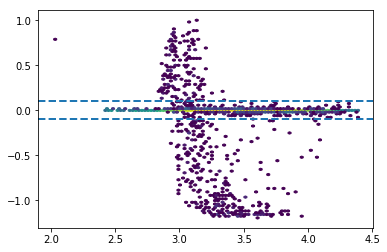

In [31]:
xmed = np.log10(out['s_med'])
ratio = np.log10((out['s_p90']-out['s_p50'])/(out['s_p50']-out['s_p10']))
plt.hexbin(xmed, ratio, mincnt=1, bins='log')
plt.axhline(y=0.1, lw=2, ls='--')
plt.axhline(y=-0.1, lw=2, ls='--')

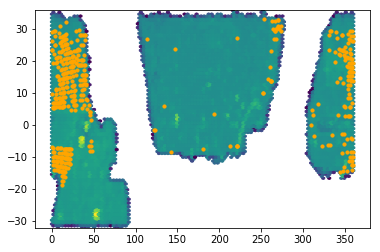

In [39]:
cut = np.abs(ratio) > 0.1
plt.hexbin(out['ra'], out['dec'], mincnt=1, bins='log')
plt.scatter(out['ra'][cut], out['dec'][cut], color='orange', s=10)

In [40]:
out[cut]

filename,sky_camera,sky_ccdname,sky_expnum,legpipev,plver,imgdsum,procdate,sky_sig1,s_mode,s_med,s_cmed,s_john,s_p0,s_p10,s_p20,s_p30,s_p40,s_p50,s_p60,s_p70,s_p80,s_p90,s_p100,s_fmaskd,s_fine,image_filename,image_hdu,camera,expnum,ccdname,object,propid,filter,exptime,mjd_obs,airmass,fwhm,width,height,ra_bore,dec_bore,crpix1,crpix2,crval1,crval2,cd1_1,cd1_2,cd2_1,cd2_2,yshift,ra,dec,skyrms,sig1,ccdzpt,zpt,ccdraoff,ccddecoff,ccdskycounts,ccdskymag,ccdrarms,ccddecrms,ccdphrms,ccdnmatch,ccd_cuts
bytes54,bytes5,bytes3,int32,bytes21,bytes8,int64,bytes19,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes120,int16,bytes9,int64,bytes5,bytes35,bytes10,bytes1,float32,float64,float32,float32,int16,int16,float64,float64,float32,float32,float64,float64,float32,float32,float32,float32,bool,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int32
decam/splinesky/00347/00347148/decam-00347148-N29.fits,decam,N29,347148,dr8-sky,V3.3.0,1359620426,2014-09-05T10:21:10,35.41355,4926.7324,4933.162,4927.277,4921.9507,-4413.624,-68.72119,-41.627342,-26.962402,-15.474121,-5.20459,4.7268553,15.202148,27.149902,43.643066,168.87402,0.8167792,414.88214,decam/DECam_CP/CP20140810_z_v2/c4d_140812_095310_ooi_z_v2.fits.fz,59,decam,347148,N29,DECaLS_4872_z,2014B-0404,z,142.0,56881.40970492,1.64,5.8808527,2046,4094,28.948208333333334,21.76311111111111,-11376.2,6306.333,28.94819283277,21.76310738499,-4.066853e-08,7.285967e-05,-7.288153e-05,-5.307347e-08,False,28.615408679269457,20.858702117746088,0.30497018,35.413567,25.017237,25.012608,0.04161468,-0.14177999,34.786247,19.721987,0.045991108,0.14281052,0.018228518,75,0
decam/splinesky/00347/00347155/decam-00347155-S4.fits,decam,S4,347155,dr8-sky,V3.3.0,237134580,2014-09-05T10:21:43,36.87407,5286.1206,5330.027,5294.9956,5265.959,-4877.47,-72.55859,-44.20586,-28.809082,-16.75,-6.0117188,4.455078,15.411621,28.00879,45.308105,2613.4648,0.8350466,691.4678,decam/DECam_CP/CP20140810_z_v2/c4d_140812_101321_ooi_z_v2.fits.fz,27,decam,347155,S4,DECaLS_4908_z,2014B-0404,z,144.0,56881.42367455,1.72,5.72379,2046,4094,31.784375000000004,23.433833333333332,2150.2,2047.0,31.78438473848,23.4338357289,-3.1902093e-08,7.286079e-05,-7.2884824e-05,-4.6135817e-08,False,31.78476993855235,23.51638061811881,2.1290815,36.87655,25.010204,25.003227,0.061708733,-0.11529579,38.0916,19.623434,0.06452094,0.121518254,0.030714942,65,0
decam/splinesky/00348/00348026/decam-00348026-N1.fits,decam,N1,348026,dr8-sky-4-ge95edd1,V3.3.0,3530391244,2014-09-05T10:50:36,36.028915,4777.583,4862.9507,4784.754,4718.542,-4993.5522,-345.0345,-125.07988,-58.16445,-34.392773,-17.862793,-3.5585938,10.401367,25.730469,46.09961,2215.0776,0.9244698,771.4342,decam/DECam_CP/CP20140810_z_v2/c4d_140815_065059_ooi_z_v2.fits.fz,31,decam,348026,N1,DECaLS_40030_z,2014B-0404,z,173.0,56884.28281283,1.93,4.7144356,2046,4094,346.9562916666667,28.21077777777778,-104.2001,14825.0,346.9562772065,28.21077050779,-1.2175622e-07,7.285786e-05,-7.289416e-05,-1.353328e-07,False,345.8997344085344,28.126145600840065,1.1187739,36.02905,24.914852,24.925596,0.006705028,-0.096795104,28.716698,19.93017,0.020697678,0.09951196,0.038279682,66,0
decam/splinesky/00426/00426127/decam-00426127-S17.fits,decam,S17,426127,dr8-sky-7-gb1d1e64,V3.6.1,2549248204,2015-03-31T11:14:10,16.237684,961.8667,975.7658,960.36804,952.515,-1212.706,-34.0653,-19.008228,-11.901654,-6.4564576,-1.6025391,3.112854,8.128522,14.10791,22.884388,1954.2058,0.70988923,164.57248,decam/DECam_CP/CP20150326/c4d_150330_042423_ooi_z_v1.fits.fz,15,decam,426127,S17,DECaLS_9763_z,2014B-0404,z,67.0,57111.1822331,1.22,4.609353,2046,4094,193.82583333333332,2.9240833333333334,6659.0,-82.66665,193.8258187896,2.924070838674,-1.528167e-07,7.285435e-05,-7.2857634e-05,-1.5087925e-07,False,193.9826019556022,3.335503264813606,0.45913112,16.21121,24.869736,24.884968,-0.1577122,-0.116672084,14.707678,20

/usr/local/anaconda3/envs/desi/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/anaconda3/envs/desi/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


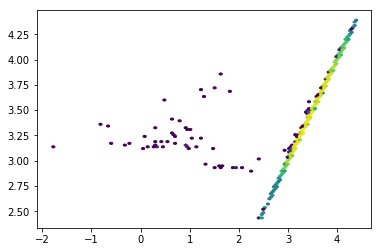

In [18]:
fig, ax = plt.subplots()
ax.hexbin(np.log10(out['s_mode']), np.log10(out['s_med']), mincnt=1, bins='log')

In [ ]:
stop

In [ ]:
out

In [ ]:
sky[sky['sig1'] > 10**2.1]

## Zeropoints

In [ ]:
data['decam-r'].dtype.names

In [ ]:
for ii, band in enumerate(('decam-g', 'decam-r', 'decam-z')):


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(14, 10))
for ii, band in enumerate(('decam-g', 'decam-r', 'decam-z')):
    basemap = init_sky(galactic_plane_color='k', ax=ax[ii])
    plot_sky_binned(data[band]['ra'], data[band]['dec'], max_bin_area=0.5, 
                clip_lo='!1', #clip_hi='95%', 
                cmap='viridis', plot_type='healpix', basemap=basemap, label=band)